# ECE-1508 Project Implementation

This python notebook contains the implementation used to implement, train, and test the deep learning model implemented for the project. It has some parts that are specific to our development environment in Google Colab, but can be adapted to run on any other environment as needed.

## Section 1: Environment Setup

In [1]:
# Initial imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

import pandas as pd
import os
import shutil
from PIL import Image
from skimage import io, transform
import math

import torchvision
from torchvision import utils
import torchvision.datasets as DS
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
from typing import Tuple

In [2]:
# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# This cell is specific to google colab
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


## Section 2: Dataset Definition and Extraction

In [4]:
# Create the dataset class that will be used with dataloaders to train the model.
# Reads a csv file containing target waypoints and the associate image paths and
# generates samples.
class CARLADataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.targets_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.targets_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.root_dir,self.targets_frame.at[idx, "file_name"])
    image = transforms.functional.to_tensor(io.imread(img_name))
    targets = self.targets_frame.iloc[idx, 0:16] # we know we have 8 waypoints
    targets = np.array([targets], dtype=float).reshape(-1, 2)
    sample = {'image': image, 'targets': targets}

    if self.transform:
        sample = self.transform(sample)

    return sample

In [5]:
# Specific to colab, unzipping a file into the VM speeds up image loading
full_dataset_path = '/content/drive/My Drive/applied_deep_learning_data/full_dataset/full_dataset.zip'
# Use the town10_dataset_path if checking map generalization
town10_dataset_path = '/content/drive/My Drive/applied_deep_learning_data/generalization_dataset/town10_dataset.zip'
shutil.unpack_archive(filename = full_dataset_path, extract_dir="/tmp/dataset/")
print(len([entry for entry in os.listdir("/tmp/dataset/full_dataset/")])) # double check number of files

120185


0 torch.Size([3, 224, 224]) (8, 2)


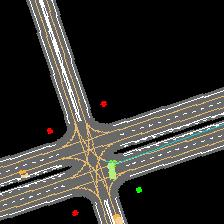

(8, 2)
[[-1.60429502e+00 -1.30965118e+02]
 [-1.10967755e-01 -1.28158249e+02]
 [-3.82067263e-01 -1.24848167e+02]
 [-6.79029167e-01 -1.21506668e+02]
 [-8.92678797e-01 -1.17969727e+02]
 [-1.03122079e+00 -1.14967964e+02]
 [-1.17481947e+00 -1.11118942e+02]
 [-1.27767348e+00 -1.07960419e+02]]
1 torch.Size([3, 224, 224]) (8, 2)


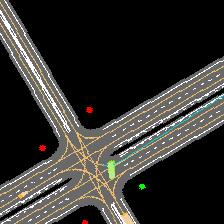

(8, 2)
[[  -1.00512636 -130.40333557]
 [  -0.13472049 -127.5309906 ]
 [  -0.45638922 -124.10166931]
 [  -0.72424573 -120.8463974 ]
 [  -0.92621803 -117.26139069]
 [  -1.05787539 -114.32367706]
 [  -1.19366431 -110.55901337]
 [  -1.29839218 -107.28116608]]
2 torch.Size([3, 224, 224]) (8, 2)


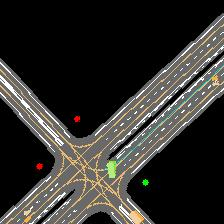

(8, 2)
[[  -0.62312871 -129.8861084 ]
 [  -0.18895561 -126.85640717]
 [  -0.52475125 -123.42232513]
 [  -0.77014512 -120.14156342]
 [  -0.957793   -116.59518433]
 [  -1.09122574 -113.4439621 ]
 [  -1.21602917 -109.89289856]
 [  -1.31940627 -106.57397461]]
3 torch.Size([3, 224, 224]) (8, 2)


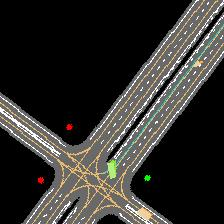

(8, 2)
[[  -0.34765708 -129.33547974]
 [  -0.25540754 -126.16887665]
 [  -0.57794362 -122.75478363]
 [  -0.81982994 -119.27636719]
 [  -0.98279333 -116.06452942]
 [  -1.11747098 -112.74687958]
 [  -1.2336092  -109.36254883]
 [  -1.34427261 -105.71482849]]


In [6]:
# Define the overall dataset that will be broken up into subsets
carla_dataset = CARLADataset('/tmp/dataset/full_dataset/targets.csv',root_dir='/tmp/dataset/full_dataset/')

# Get 4 samples to check data
to_image = transforms.ToPILImage()
for i, sample in enumerate(carla_dataset):
    print(i, sample['image'].shape, sample['targets'].shape)
    img = to_image(sample['image'])
    display(img)
    print(sample['targets'].shape)
    print(sample['targets'])

    if i == 3:
        break

In [ ]:
# Split datasets into train (80%), validation (10%), and test(10%).
train_length = int(0.8*len(carla_dataset))
validation_length = int(0.1*len(carla_dataset))
test_length = len(carla_dataset) - train_length - validation_length
train_set, validation_set, test_set = torch.utils.data.random_split(carla_dataset, [train_length,validation_length,test_length])

print("train_length:", train_length, "validation_length:", validation_length, "test_length:", test_length)

In [ ]:
# Save datasets for consistency in iterative training (only do this the first time)
torch.save(train_set, "/content/drive/My Drive/applied_deep_learning_data/datasets/train.dataset")
torch.save(validation_set, "/content/drive/My Drive/applied_deep_learning_data/datasets/validation.dataset")
torch.save(test_set, "/content/drive/My Drive/applied_deep_learning_data/datasets/test.dataset")

In [7]:
# Load separated datasets (run this every time)
train_set = torch.load("/content/drive/My Drive/applied_deep_learning_data/datasets/train.dataset")
validation_set = torch.load("/content/drive/My Drive/applied_deep_learning_data/datasets/validation.dataset")
test_set = torch.load("/content/drive/My Drive/applied_deep_learning_data/datasets/test.dataset")

## Section 3: Model Definition

In [8]:
class Model(nn.Module):
  def __init__(self, H = 8) -> None:
    # VGG16 implementation
    super(Model, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU()
    )
    self.conv4 = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv5 = nn.Sequential(
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU()
    )
    self.conv6 = nn.Sequential(
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU()
    )
    self.conv7 = nn.Sequential(
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv8 = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    )
    self.conv9 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    )
    self.conv10 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv11 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    )
    self.conv12 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU()
    )
    self.conv13 = nn.Sequential(
      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(7*7*512, 4096),
      nn.ReLU()
    )
    self.fc1 = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(4096, 1000),
      nn.ReLU()
    )
    self.fc2 = nn.Sequential(
      nn.Linear(1000, 2*H)
    )
  def forward(self, x: torch.Tensor) -> int:
    h = self.conv1(x)
    h = self.conv2(h)
    h = self.conv3(h)
    h = self.conv4(h)
    h = self.conv5(h)
    h = self.conv6(h)
    h = self.conv7(h)
    h = self.conv8(h)
    h = self.conv9(h)
    h = self.conv10(h)
    h = self.conv11(h)
    h = self.conv12(h)
    h = self.conv13(h)
    h = h.reshape(h.size(0), -1)
    h = self.fc(h)
    h = self.fc1(h)
    y = self.fc2(h)

    return y

In [ ]:
# Feed pretrained VGG16 wights to the model to help speed up training
vgg16 = models.vgg16(pretrained=True)

def feed_vgg_to_model(model):
  # Transfer weights and bias for each layer
  model.conv1[0].weight.data = vgg16.features[0].weight.data
  model.conv1[0].bias.data = vgg16.features[0].bias.data

  model.conv2[0].weight.data = vgg16.features[2].weight.data
  model.conv2[0].bias.data = vgg16.features[2].bias.data

  model.conv3[0].weight.data = vgg16.features[5].weight.data
  model.conv3[0].bias.data = vgg16.features[5].bias.data

  model.conv4[0].weight.data = vgg16.features[7].weight.data
  model.conv4[0].bias.data = vgg16.features[7].bias.data

  model.conv5[0].weight.data = vgg16.features[10].weight.data
  model.conv5[0].bias.data = vgg16.features[10].bias.data

  model.conv6[0].weight.data = vgg16.features[12].weight.data
  model.conv6[0].bias.data = vgg16.features[12].bias.data

  model.conv7[0].weight.data = vgg16.features[14].weight.data
  model.conv7[0].bias.data = vgg16.features[14].bias.data

  model.conv8[0].weight.data = vgg16.features[17].weight.data
  model.conv8[0].bias.data = vgg16.features[17].bias.data

  model.conv9[0].weight.data = vgg16.features[19].weight.data
  model.conv9[0].bias.data = vgg16.features[19].bias.data

  model.conv10[0].weight.data = vgg16.features[21].weight.data
  model.conv10[0].bias.data = vgg16.features[21].bias.data

  model.conv11[0].weight.data = vgg16.features[24].weight.data
  model.conv11[0].bias.data = vgg16.features[24].bias.data

  model.conv12[0].weight.data = vgg16.features[26].weight.data
  model.conv12[0].bias.data = vgg16.features[26].bias.data

  model.conv13[0].weight.data = vgg16.features[28].weight.data
  model.conv13[0].bias.data = vgg16.features[28].bias.data

  return model

## Section 4: Training Setup

In [9]:
# Definition for Square Displacement Error loss used for training
class SquareDispError(nn.Module):
  def __init__(self, H:int):
    super(SquareDispError, self).__init__()
    self.H = H

  def forward(self, outputs, targets):
    loss = 0
    for j in range(targets.shape[0]):
      target = targets[j].view(self.H*2,1)
      output = outputs[j]
      sample_loss = 0
      for i in range(self.H):
        sample_loss += (pow(target[i*2] - output[i*2], 2) + pow(target[i*2+1] - output[i*2+1], 2))
      sample_loss = sample_loss/float(self.H)
      loss = loss + sample_loss

    return loss

# Definition for Waypoint Displacement Error loss to get human understandable values
# in testing
class WaypointDispError(nn.Module):
  def __init__(self, H:int):
    super(WaypointDispError, self).__init__()
    self.H = H

  def forward(self, outputs, targets):
    loss = 0
    num_waypoints = 0
    for j in range(targets.shape[0]):
      target = targets[j].view(self.H*2,1)
      output = outputs[j]
      for i in range(self.H):
        num_waypoints+=1
        loss += math.sqrt(pow(target[i*2] - output[i*2], 2) + pow(target[i*2+1] - output[i*2+1],2))

    return loss/num_waypoints

In [10]:
# Run a test against a specific loader using a specified loss function
def test(model, loader, loss_fn) -> float:
  with torch.no_grad():
    risk = 0

    for i, data in enumerate(loader):
      images = data['image'].to(device)
      labels = data['targets'].to(device)

      outputs = model.forward(images)
      loss = loss_fn(outputs, labels)
      if isinstance(loss, float):
        risk += loss
      else:
        risk += loss.item()

    test_risk = risk / i

    return test_risk

In [ ]:
# The main training loop. Given a model, loss function, batch_size, learning rate, and epoch count to train for,
# this function will run training using the training dataset, validate using the validation dataset,
# and save the trained model and risks every epoch to be used in iterative training
def train(model, loss_fn, batch_size, learning_rate, num_epochs, output_folder) -> Tuple[float, float]:
  train_risk = []
  validation_risk = []

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

  model.train()
  model.to(device)
  with tqdm(range(num_epochs), unit="Epochs") as epoch_bar:
    epoch_bar.set_description("Training Loop")
    for epoch in epoch_bar:
      # training risk in one epoch
      risk = 0

      for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        labels = data['targets'].to(device)
        labels = labels.reshape(labels.shape[0],16)

        # forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        risk += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      model.eval()
      val_risk_epoch = test(model, validation_loader, loss_fn)

      # collect losses and accuracy
      train_risk.append(risk / i)
      validation_risk.append(val_risk_epoch)

      # save model and risks for iterative training
      model_filename = "model_bs{}_lr{}_epoch{}".format(batch_size,learning_rate,epoch)
      model_filepath = os.path.join(output_folder,model_filename)
      torch.save(model, model_filepath)

      np.save(os.path.join(model_output_folder,"train_risk_bs{}_lr{}".format(batch_size,learning_rate)), train_risk)
      np.save(os.path.join(model_output_folder,"validation_risk_bs{}_lr{}".format(batch_size,learning_rate)), validation_risk)

  return train_risk, validation_risk

## Section 5: Iterative Training

In [ ]:
# Load previously trained model (optional)
loaded_model = torch.load("/content/drive/My Drive/applied_deep_learning_data/models/Training4/model_bs50_lr0.0001_epoch4")

In [ ]:
# Define hyperparameters for iterative training.
H = 8 # num waypoints ahead
batch_size = 50
learning_rate = 0.00001
loss_function = SquareDispError(H)
num_epochs = 10
model_output_folder = "/content/drive/My Drive/applied_deep_learning_data/models"

# Train the loaded model using the hyperparameters above
train_risk, validation_risk = train(loaded_model, loss_function, batch_size, learning_rate, num_epochs, model_output_folder)

## Section 6: Data Visualization

This section contains some of the data visualization produced for the report, though some cells are removed for readability.

In [11]:
# Produces plots of risk for a given experiment
def plot_experiment(batch_size, learning_rate, epochs_start, train_risk = None, validation_risk = None, test_risk = None):
  # plot the losses
  if train_risk is not None:
    train_x = np.arange(epochs_start, epochs_start + len(train_risk)).reshape(len(train_risk),1)
    plt.plot(train_x, train_risk.reshape(len(train_risk),1), label='Training risk')
  if validation_risk is not None:
    val_x = np.arange(epochs_start, epochs_start + len(validation_risk)).reshape(len(validation_risk),1)
    plt.plot(val_x, validation_risk.reshape(len(validation_risk),1), label='Validation risk')
  if test_risk is not None:
    plt.scatter([epochs_start + len(validation_risk)],test_risk, label='Test risk')
  plt.xlabel("Epoch")
  plt.ylabel("Risk")
  plt.xticks(np.arange(epochs_start, epochs_start + len(train_risk)))
  subtitle = "batch_size: {}, learning_rate: {}".format(batch_size,learning_rate)
  plt.title("Experiment Risks \n {}".format(subtitle))
  plt.legend()
  plt.grid()
  plt.show()

In [12]:
# Load trained model and risks as needed for checking data
trained_model = torch.load("/content/drive/My Drive/applied_deep_learning_data/models/Training5/model_bs50_lr1e-05_epoch9")
final_training_risk = np.concatenate((np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training2/train_risk_bs50_lr0.0001.npy"),
                                     np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training3/train_risk_bs50_lr0.0001.npy"),
                                     np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training4/train_risk_bs50_lr0.0001.npy"),
                                      np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training5/train_risk_bs50_lr1e-05.npy")))
final_validation_risk = np.concatenate((np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training2/validation_risk_bs50_lr0.0001.npy"),
                                       np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training3/validation_risk_bs50_lr0.0001.npy"),
                                       np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training4/validation_risk_bs50_lr0.0001.npy"),
                                        np.load("/content/drive/My Drive/applied_deep_learning_data/models/Training5/validation_risk_bs50_lr1e-05.npy")))

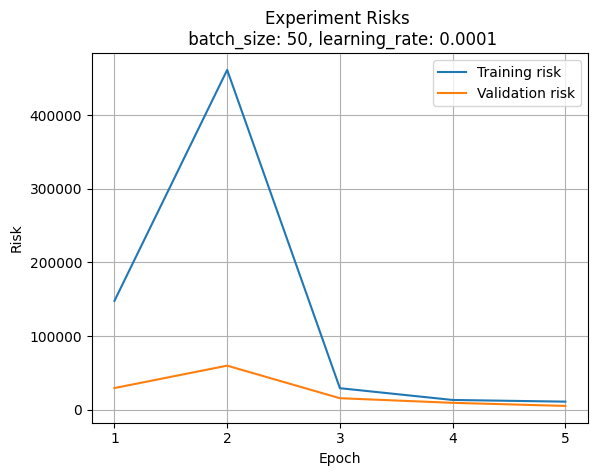

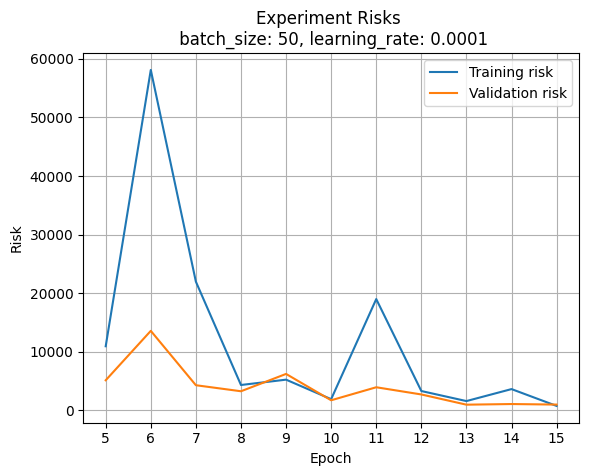

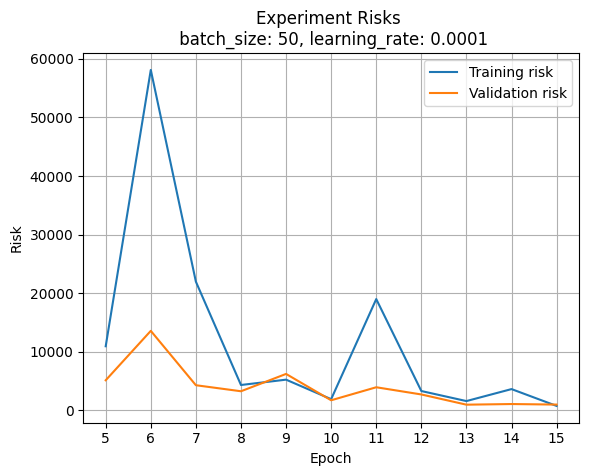

In [14]:
# Risk plot for epochs 1 to 5
plot_experiment(50, 0.0001, 1, final_training_risk[0:5], final_validation_risk[0:5])

# Risk plot for epochs 5 to 15
plot_experiment(50, 0.0001, 5, final_training_risk[4:15], final_validation_risk[4:15])

# Risk plot for epochs 15 to 25
plot_experiment(50, 0.0001, 5, final_training_risk[4:15], final_validation_risk[4:15])

In [15]:
# Load models at specific epochs to get test risk and displacement error
model_at_15 = torch.load("/content/drive/My Drive/applied_deep_learning_data/models/Training4/model_bs50_lr0.0001_epoch4")
model_at_20 = torch.load("/content/drive/My Drive/applied_deep_learning_data/models/Training5/model_bs50_lr1e-05_epoch4")
model_at_25 = torch.load("/content/drive/My Drive/applied_deep_learning_data/models/Training5/model_bs50_lr1e-05_epoch9")

In [16]:
# Get test risk and test waypoint displacement error
sde_loss = SquareDispError(8)
wde_loss = WaypointDispError(8)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)
test_risk = test(model_at_25, test_loader, sde_loss)
test_wde = test(model_at_25, test_loader, wde_loss)
print(test_risk)
print(test_wde)

296.0444609721661
1.6136944911565345
